In [1]:
import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import models
import tensorflow.keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
import os

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
if not os.path.isdir("model"):
    os.mkdir("model")

In [4]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'
         }
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.style.context('default')

In [5]:
# Loading training/testing data
data_train = np.load('data/jetListTrain.npz')
data_test = np.load('data/jetListTest.npz')
batch = len(data_train['pt1'][1])
feat_all = [key for key in data_train.keys()]
feat_all.remove('labels')
print('Dataset features:')
print(feat_all)
print('Dataset size:')
print(len(data_train['pt1']))
print()

Dataset features:
['pt1', 'pt2', 'dtheta1', 'dtheta2', 'dphi1', 'dphi2', 'theta', 'r1', 'r2', 'z']
Dataset size:
2000000



In [6]:
def build_model(n):
    
    inpts = []
    xlayers = []
    for i in range(n):
        inpt = layers.Input(shape = (batch,1))
        
        x = layers.Conv1D(64, 3, padding = 'same', activation='relu')(inpt)
        x = layers.Conv1D(64, 1, padding = 'same', activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.MaxPool1D(2)(x)
        x = layers.Conv1D(32, 3, padding = 'same', activation='relu')(x)
        x = layers.Conv1D(32, 1, padding = 'same', activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.MaxPool1D(2)(x)
        x = layers.Flatten()(x)
        
        inpts.append(inpt)
        xlayers.append(x)
    
    if(n > 1):
        x = layers.concatenate(inputs=xlayers, axis=-1)

    x = layers.Dense(64, activation='relu', name = 'relu')(x)
    output = layers.Dense(2, activation='softmax', name = 'output')(x)
    model = models.Model(inputs=inpts, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    
    return model

In [7]:
def build_XY(features,label,dic):
    X = [dic[key] for key in features]
    Y = [dic[key] for key in label]
    return X,Y
features = [feat_all[i] for i in range(6)]
X_train, Y_train = build_XY(features,['labels'],data_train)
X_test, Y_test = build_XY(features,['labels'],data_test)

In [8]:
CNN = build_model(len(features))

In [9]:
X_batch = [ele[:10] for ele in X_train]
Y_batch = [ele[:10] for ele in Y_train]
example_result = CNN.predict(x = X_batch)
results = CNN.evaluate(x = X_batch, y = Y_batch )

/home/cebarros/Tensorflow/Tensorflow_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [10]:
X_batch = [ele for ele in X_train]
Y_batch = [ele for ele in Y_train]
X_batch_test = [ele for ele in X_test]
Y_batch_test = [ele for ele in Y_test]

In [11]:
checkpoint_path = "model/1D_CNN.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch')    
EPOCHS = 5
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = 1.0e-6)
history = CNN.fit(
  X_batch, Y_batch,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 0.11136, saving model to model/1D_CNN.h5

Epoch 00002: val_loss did not improve from 0.11136

Epoch 00003: val_loss did not improve from 0.11136

Epoch 00004: val_loss did not improve from 0.11136

Epoch 00005: val_loss did not improve from 0.11136


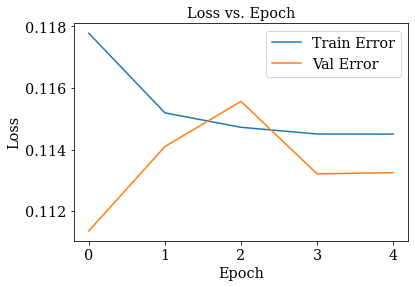

In [12]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    plt.show()

plot_history(history)

In [13]:
best_model = keras.models.load_model('model/1D_CNN.h5')
best_model.summary()
results = best_model.evaluate(X_batch_test, Y_batch_test, verbose = 0)
print(results)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10, 1)]      0                                            
________________________________________________________

/home/cebarros/Tensorflow/Tensorflow_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


[0.11250000433555245, 0.11250071, 0.962899]


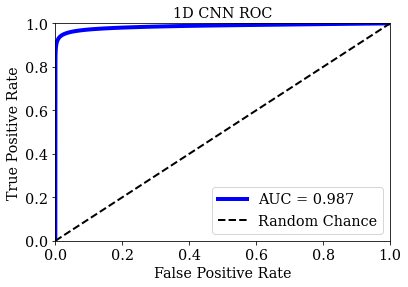

In [14]:
predict = best_model.predict(X_batch_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_batch_test[0][:][:,0], predict[:][:,0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=4, color='b', label='AUC = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('1D CNN ROC')
plt.legend(loc="lower right")
plt.show()

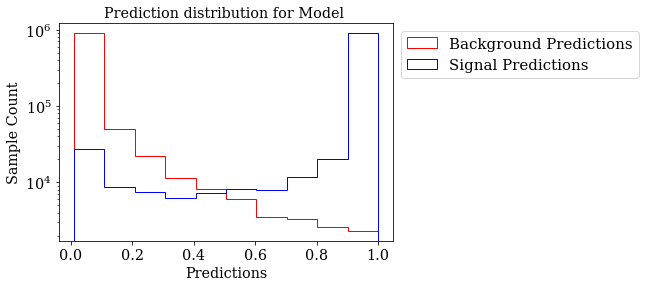

In [15]:
sig_pred = predict[np.argwhere(Y_batch_test[0][:,0]==1.).squeeze()].squeeze()
bkg_pred = predict[np.argwhere(Y_batch_test[0][:,0]==0.).squeeze()].squeeze()
plt.hist([sig_pred[:,0], bkg_pred[:,0]], 
          color = ['blue', 'red'], histtype = 'step', label = ['Signal Predictions', 'Background Predictions'])
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
plt.title('Prediction distribution for Model ')
plt.xlabel('Predictions')
plt.ylabel('Sample Count')
plt.show()